In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import CubicSpline, interp1d

In [3]:
# --- Adjust parameters and Load Data---

lower_limit_G, upper_limit_G, color_index_upper_lim = 20, 10, 1.5  #hard limits for the photometric parameters
bprp, gmag = np.loadtxt("NGC6397.txt", unpack=True, skiprows=1)  #input data, file with two columns: color index and g band brightness

# Data Preparation

In this section we search for the bluest point in the color-magnitude diagram (CMD), This is useful for example in isochrone fitting, where we need to know the position of the main sequence turn-off (MSTO) point. The LOWESS (Locally Weighted Scatterplot Smoothing) method is applied to determine the primary ridgeline of the CMD. Then the numerical derivative of the ridge line is calculated, which is used to determine the slope of the ridgeline. This slope is used to rotate the points in the CMD, so that the ridgeline is horizontal in the transformed coordinate system.

In [4]:
arr = np.column_stack((bprp, gmag))
arr = arr[(arr[:, 1] < lower_limit_G) & ~((arr[:, 0] < color_index_upper_lim) & (arr[:, 1] < upper_limit_G))]
df = pd.DataFrame(arr, columns=['bprp', 'gmag']).dropna().sort_values('gmag')
df[['ridge_bprp', 'ridge_gmag']] = lowess(df['bprp'], df['gmag'], frac=0.2)[:, [1, 0]]
blue_x, blue_y = df.loc[df['ridge_bprp'].idxmin(), ['ridge_bprp', 'ridge_gmag']]
#cut2_points_x, cut2_points_y = blue_x + 0.3, blue_y - 2


def numerical_derivative(x, y):
    x, y = np.asarray(x), np.asarray(y)
    d = np.zeros_like(y)
    d[0] = (y[1] - y[0]) / (x[1] - x[0])
    d[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    d[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
    return d

def rotate_points(x, y, rx, ry, inverse=False):
    a = np.arctan(numerical_derivative(ry, rx))
    if inverse:
        a = -a
    c, s = np.cos(a), np.sin(a)
    x_rot = x * c - y * s
    y_rot = x * s + y * c
    if not inverse:
        y_rot += ry
    return x_rot, y_rot

# --- Rotation and Binning ---
df[['x_new', 'y_new']] = np.column_stack(
    rotate_points(df['bprp']-df['ridge_bprp'], df['gmag']-df['ridge_gmag'], df['ridge_bprp'], df['ridge_gmag'])
)
df["x_new0"] = 0
df = df.sort_values(by='y_new')

We separate the datapoints into N number of bins along the Y axis. Then we calculate KDE (Kernel Density Estimate) values along the X axis of each bin and calculate the median values along the Y axis. The maximum values of the KDEs became the X coordinate and the median values became the Y coordinates of the N well-defined bin points. We connect these points with a cubic spline. Then we transform everything back into the original coordinate system where the interpolated cubic spline becomes the new ridgeline. This way, the new ridgeline now closely follows the turnoff point and the RGB.

In [5]:
bins = np.array([11.5,12,13,14,15,15.6,16,17,18,19,19.5]) #Adjust the bins as needed

bin_labels = [str(b) for b in bins[:-1]]
df['bin'] = pd.cut(df['y_new'], bins=bins, labels=bin_labels, right=False)

# --- KDE Calculation ---
def calculate_kde(df, column, y_column, bandwidth='scott'):
    results = []
    for bin_label, group in df.groupby('bin', observed=False):
        if group[column].empty:
            continue
        fig, ax = plt.subplots()
        kde_plot = sns.kdeplot(group[column], bw_method=bandwidth, ax=ax)
        xxx, yyy = kde_plot.lines[0].get_data()
        plt.close(fig)
        idx_max = pd.Series(yyy).idxmax()
        results.append({
            'bin': bin_label,
            'x_at_max_density': xxx[idx_max],
            'median_y': group[y_column].median()
        })
    return results

kde_results = calculate_kde(df, 'x_new', 'y_new')
results_df = pd.DataFrame(kde_results).sort_values(by='median_y')
y_sorted = results_df['median_y'].values
x_sorted = results_df['x_at_max_density'].values

# --- Interpolation and Inverse Rotation ---
cs = CubicSpline(y_sorted, x_sorted)
mask = (df['y_new'] >= bins[0]) & (df['y_new'] < bins[-1])
df.loc[mask, 'x_interpolate'] = cs(df.loc[mask, 'y_new'])
df.loc[~mask, 'x_interpolate'] = np.nan  

df['x_back2'], df['y_back2'] = rotate_points(
    df['x_interpolate'], df['y_new'] - df['ridge_gmag'], df['ridge_bprp'], df['ridge_gmag'], inverse=True
)
df['x_back2'] += df['ridge_bprp']
df['y_back2'] += df['ridge_gmag']

# --- Final Sorting and Linear Interpolation ---
df_sorted = df[['x_back2', 'y_back2']].sort_values(by='y_back2').dropna().reset_index(drop=True)
x_sorted = df_sorted['x_back2'].values
y_sorted = df_sorted['y_back2'].values
linear_interp = interp1d(y_sorted, x_sorted, kind='linear', fill_value="extrapolate")
y_fine2 = np.linspace(y_sorted.min(), y_sorted.max(), 10000)
x_fine2 = linear_interp(y_fine2)

/tmp/ipykernel_3341/3890085491.py:13: RuntimeWarning: invalid value encountered in divide
  d[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])


## Visualization

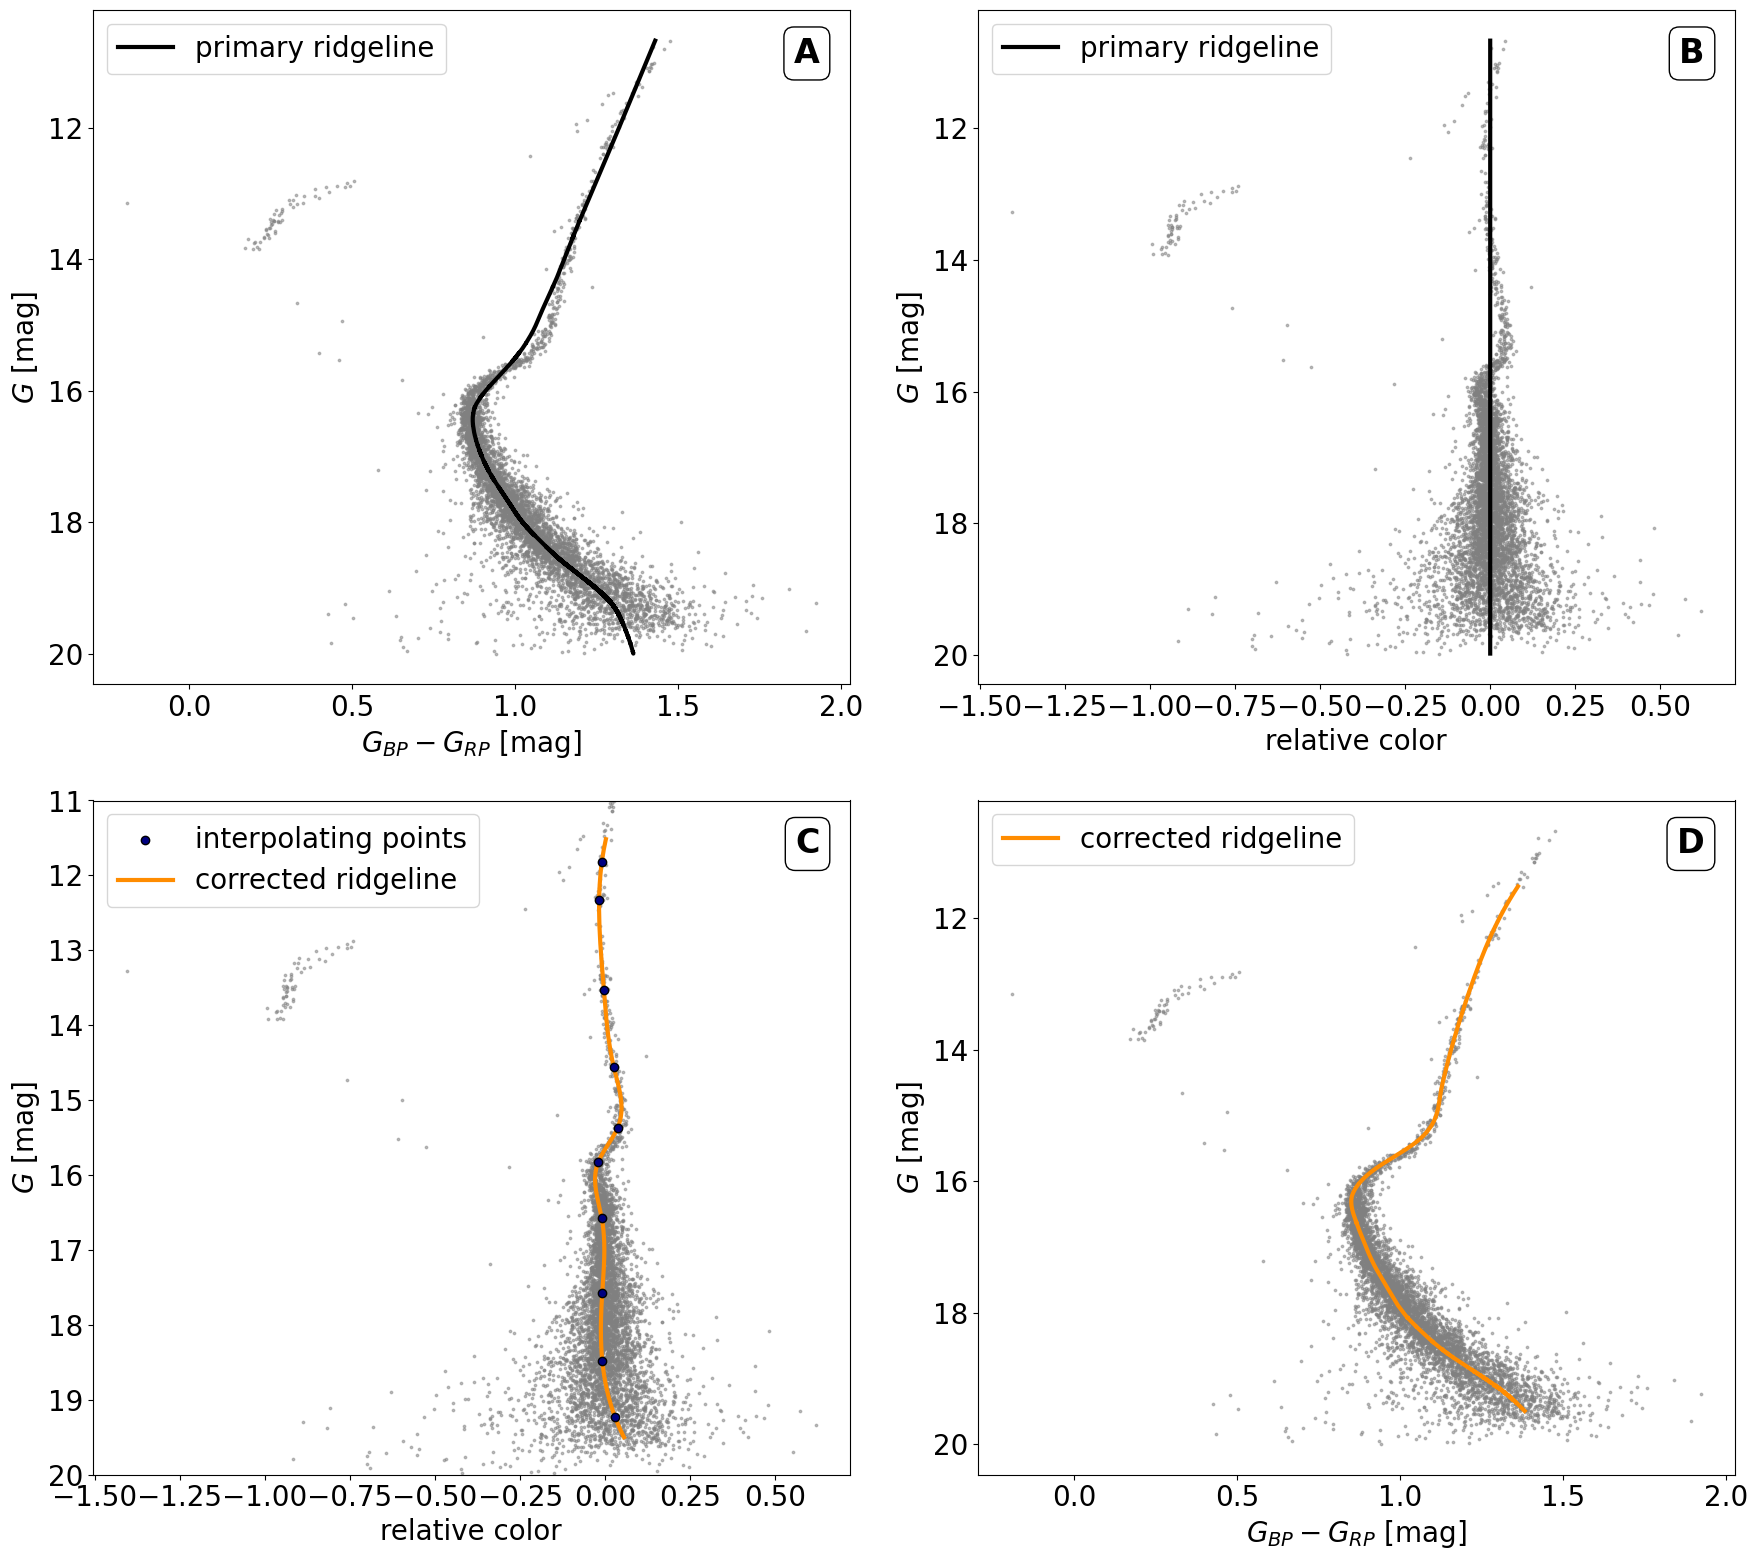

In [ ]:
# Set the font size and family for the plot
plt.rcParams.update({'font.size': 20})
#plt.rcParams["font.family"] = "Liberation Serif" ## specital font family, can be changed to any other font family installed on the system

# Set the point size and transparency
s = 3
alpha = 0.5

fig, axs = plt.subplots(2, 2, figsize=(18, 16))

# Top left: CMD with primary ridgeline
axs[0, 0].invert_yaxis()
#axs[0, 0].set_xlim(0.75, 1.5)
axs[0, 0].scatter(df['bprp'], df['gmag'], s=s, c='grey', alpha=alpha)
axs[0, 0].plot(df['ridge_bprp'], df["ridge_gmag"], c="black", lw=3, label="primary ridgeline")
axs[0, 0].set_xlabel('$G_{BP}-G_{RP}$ [mag]')
axs[0, 0].set_ylabel('$G$ [mag]')
axs[0, 0].legend(loc='upper left')

# Top right: Rotated CMD with primary ridgeline
axs[0, 1].invert_yaxis()
#axs[0, 1].set_xlim(-0.6, 0.4)
axs[0, 1].scatter(df['x_new'], df['y_new'], s=s, color='grey', alpha=alpha)
axs[0, 1].plot(df['x_new0'], df['y_new'], c="black", lw=3, label="primary ridgeline")
axs[0, 1].set_xlabel('relative color')
axs[0, 1].set_ylabel('$G$ [mag]')
axs[0, 1].legend(loc='upper left')

# Bottom left: Rotated CMD with KDE maxima and interpolated curve
axs[1, 0].invert_yaxis()
#axs[1, 0].set_xlim(-0.6, 0.4)
axs[1, 0].set_ylim(20, 11)
axs[1, 0].scatter(df['x_new'], df['y_new'], s=s, color='grey', alpha=alpha)
axs[1, 0].scatter(results_df['x_at_max_density'].values, results_df['median_y'].values, edgecolor='black', color='navy', zorder=3, label="interpolating points")
axs[1, 0].plot(df['x_interpolate'], df['y_new'], c="darkorange", zorder=1, lw=3, label="corrected ridgeline")
axs[1, 0].set_xlabel('relative color')
axs[1, 0].set_ylabel('$G$ [mag]')
axs[1, 0].legend(loc='upper left')


# Bottom right: CMD with corrected ridgeline
axs[1, 1].invert_yaxis()
#axs[1, 1].set_xlim(0.75, 1.5)
axs[1, 1].scatter(df['bprp'], df['gmag'], s=s, color='grey', alpha=alpha)
axs[1, 1].plot(df['x_back2'], df['y_back2'], color='darkorange', lw=3, label="corrected ridgeline")
axs[1, 1].set_xlabel('$G_{BP}-G_{RP}$ [mag]')
axs[1, 1].set_ylabel('$G$ [mag]')
axs[1, 1].legend()

## Add annotation for the panels a, b, c, d
axs[0, 0].annotate('A', xy=(0.96, 0.96), xycoords='axes fraction', fontsize=24, fontweight='bold',
                  ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
axs[0, 1].annotate('B', xy=(0.96, 0.96), xycoords='axes fraction', fontsize=24, fontweight='bold',
                  ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
axs[1, 0].annotate('C', xy=(0.96, 0.96), xycoords='axes fraction', fontsize=24, fontweight='bold',
                  ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
axs[1, 1].annotate('D', xy=(0.96, 0.96), xycoords='axes fraction', fontsize=24, fontweight='bold',
                  ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.tight_layout()
#plt.savefig("ridgeline_analysis.png", dpi=300)
plt.show()


## Supplementary features

### Only the final ridgeline plot

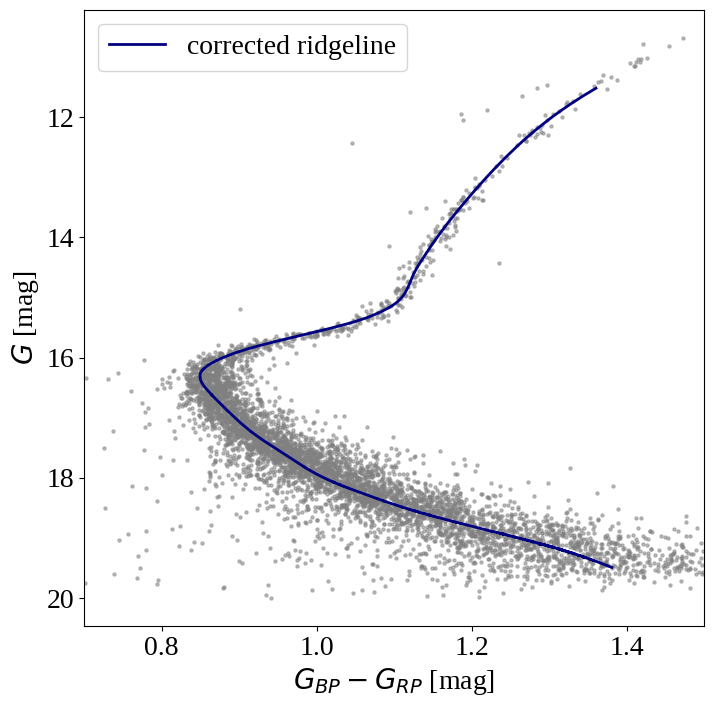

In [20]:
fig = plt.figure(figsize=(8,8))
plt.gca().invert_yaxis() 

## Adjust limits according to your data
plt.xlim(0.7,1.5)

plt.scatter(df['bprp'],df['gmag'], s=s, alpha=alpha, color='grey')
#plt.plot(df['ridge_bprp'], df["ridge_gmag"], c="darkorange", lw=2, label="primary ridgeline")
plt.plot(df['x_back2'], df['y_back2'],color='navy',lw=2, label="corrected ridgeline")

plt.xlabel('$G_{BP}-G_{RP}$ [mag]', fontsize=20)
plt.ylabel('$G$ [mag]', fontsize=20)
plt.legend()

#plt.savefig("ridge_NGC6379.png", dpi=300)
plt.show()